## Install and Import Libraries

In [1]:
# install dependencies
!pip3 install tqdm      #shows a smart progress meter while executing the loops in code
!pip3 install pillow --upgrade      #for image processing

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 2.2 MB 3.2 MB/s eta 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
# import libraries

%matplotlib inline

import numpy as np
import os
import tarfile    #for reading and writing tar archive files
import urllib     #for handling urls
import shutil     #for high level operations on files and collection of files
import json       #javascript object notation
import random
import boto3      #to create, configure and maange aws services such as EC2 and S3
import sagemaker  #for training and deploying machine learning models on amazon sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
import matplotlib.pyplot as plt
from xml.etree import ElementTree as ET     #to read and manipulate xml tree structures
from PIL import Image, ImageDraw, ImageFont

## Download and Extract the Data

In [3]:
# url for the oxford IIIT pets dataset
urls = ["http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz",
       "http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"]

In [4]:
#function to download and extract the data

def download_and_extract(data_dir, download_dir):
    
    """Function to download and extract the Oxford IIIT Pets Dataset.
    Input args: data_dir = directory where the data will be downloaded
                download_dir = url for the data to be downloaded"""
    
    for url in urls:
        target_file = url.split("/")[-1]    #access the file name from the url
        if target_file not in os.listdir(download_dir):
            print("Downloading", url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))  #retrieve the url in a temporary location in disk
            tf = tarfile.open(url.split("/")[-1])
            tf.extractall(data_dir)
        else:
            print("Data already downloaded", url)

In [5]:
# make a data directory if it does not exist
if not os.path.isdir("data"):
    os.mkdir("data")

In [6]:
# download and extract the data
download_and_extract("data", ".")

Data already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Data already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


## Extract the annotations from the XML Format

Now that the data is downloaded we have acquired the images for training our model. But the annotations are in XML format. If we look into one of the XML files we will see it contains the object class information and also the bound boxes which indicates the size of the face of the pet object that we will train our model on. So, the next step becomes extracting these information from the xml files.

In [7]:
xml_dir = "data/annotations/xmls"    #define the xml directory
xml_files = [os.path.join(xml_dir, x) for x in os.listdir(xml_dir) if x[-3:] == "xml"]  #make a list of paths of xml files
xml_files[0]   #print the first element of the list

'data/annotations/xmls/British_Shorthair_148.xml'

In [8]:
len(xml_files)

3686

In [9]:
# define the classes of cat and dog and give them corresponding class id
classes = ["cat", "dog"]
categories = [
    {
        "class_id":0,
        "name":"cat"
    },
    {
        "class_id":1,
        "name":"dog"
    }
]

In the next step we extract the files from xml_files and convert them in a json format. This is because when we use mxnet in aws sagemaker it expects the data to be structured in a json file format. So, now we convert the xml annotations to json annotations.

In [10]:
def convert_annotations_xml_to_json(xml_file_path):
    
    """Function to convert the xml annotations into json annotations"""
    
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    annotation = {}
    
    annotation["file"] = root.find("filename").text
    annotation["categories"] = categories
    size = root.find("size")
    annotation["image_size"] = [{
        "width": int(size.find("width").text),
        "height": int(size.find("height").text),
        "depth": int(size.find("depth").text)
    }]
    
    annotation["annotations"] = []
    
    for item in root.iter("object"):
        class_id = classes.index(item.find("name").text)
        ymin, xmin, ymax, xmax = None, None, None, None
        
        for box in item.findall("bndbox"):
            xmin = int(box.find("xmin").text)
            ymin = int(box.find("ymin").text)
            xmax = int(box.find("xmax").text)
            ymax = int(box.find("ymax").text)
            
            if all([xmin, ymin, xmax, ymax]) is not None:
                annotation["annotations"].append({
                    "class_id":class_id,
                    "left":xmin,
                    "top":ymin,
                    "width":xmax - xmin,
                    "height":ymax - ymin
                })
                
    return annotation

In [11]:
convert_annotations_xml_to_json(xml_files[0])

{'file': 'British_Shorthair_148.jpg',
 'categories': [{'class_id': 0, 'name': 'cat'},
  {'class_id': 1, 'name': 'dog'}],
 'image_size': [{'width': 500, 'height': 281, 'depth': 3}],
 'annotations': [{'class_id': 0,
   'left': 205,
   'top': 46,
   'width': 72,
   'height': 69}]}

## Data Visualization

In [12]:
def plot_image(plt, annot, image_file_path, rows, cols, index):
    
    """Function to plot image from the data"""
    
    img = Image.open(image_file_path)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("/usr/share/fonts/dejavu/DejaVuSerif-Bold.ttf", 20)
    
    for a in annot["annotations"]:
        box = [
            int(a["left"]), int(a["top"]),
            int(a["left"]) + int(a["width"]),
            int(a["top"]) + int(a["height"])
        ]
        draw.rectangle(box, outline = "yellow", width = 4)
        draw.text((box[0], box[1]), classes[int(a["class_id"])], font = font)
    plt.subplot(rows, cols, index + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    
    return plt

In [13]:
def show_random_annotations(plt):
    
    """Function to show random annotations from the data"""
    
    plt.figure(figsize=(16,16))
    for i in range(0,9):
        index = random.randint(0, len(xml_files)-1)
        annot = convert_annotations_xml_to_json(xml_files[index])
        image_file_path = os.path.join("data/images/", annot["file"])
        
        plt = plot_image(plt, annot, image_file_path, 3, 3, i)
        
    plt.show()

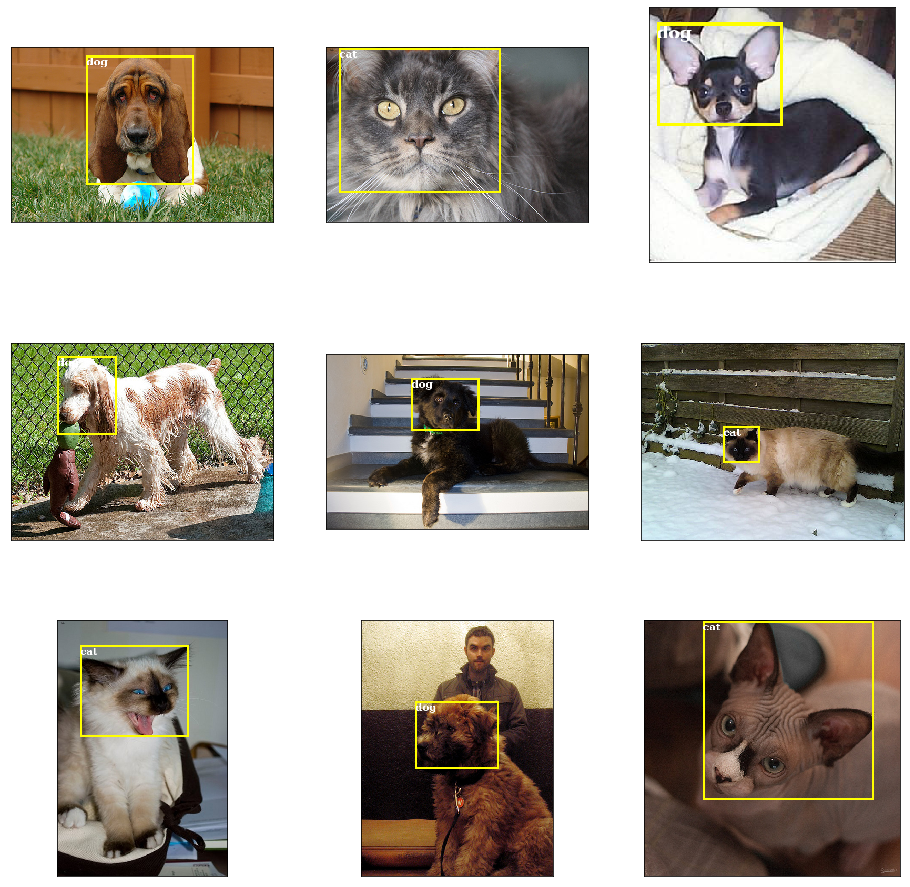

In [14]:
show_random_annotations(plt)

We see from the random image plots that all the faces are annotated. The bound box allows us to annotate only the faces. We also see that the boxes also contain the class of the image i.e., cat and dog.

## Setting up SageMaker

In [15]:
role = sagemaker.get_execution_role()     # set up an execution role
bucket = "intekhabpetsdata"    # bucket to store all the training data

# training image is a docker image where all our code will be executed during training
training_image = get_image_uri(boto3.Session().region_name, "object-detection", repo_version = "latest")
print(training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


825641698319.dkr.ecr.us-east-2.amazonaws.com/object-detection:1


In [16]:
# create blank folders according to the sagemaker object-detection algorithm. the structure of the folders is unique
# and must be the same for every case

folders = ["train", "train_annotation", "validation", "validation_annotation"]

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

After doing this we need to create the bucket in S3 so that we can store all our data there. At this stage we go to AWS console and create a bucket with the same name that we already created in the code.

## Preparation of Data for SageMaker

In [17]:
# check the length of our dataset
print("Total number of samples:", len(xml_files))

Total number of samples: 3686


In [18]:
for xml_file in tqdm(xml_files):
    target_set = "train" if random.randint(0,99) < 75 else "validation" # randomly select samples for train and validation
    annot = convert_annotations_xml_to_json(xml_file) # extract the annotations for each file
    image_file_path = os.path.join("data/images/", annot["file"])
    image_target_path = os.path.join(target_set, annot["file"])
    shutil.copy(image_file_path, image_target_path)
    json_file_path = os.path.join(target_set + "_annotation", annot["file"][:-3] + "json")
    with open(json_file_path, "w") as f:
        json.dump(annot, f)

100%|██████████| 3686/3686 [00:11<00:00, 317.07it/s]


In [19]:
train_images = os.listdir("train")
train_annots = os.listdir("train_annotation")
print(len(train_images), len(train_annots))

2766 2766


In [20]:
# check if the image name in train and annotation folder correspondingly match with each other
for image in train_images:
    key = image.split(".")[0]
    json_file = key + ".json"
    if json_file not in train_annots:
        print("Not found", json_file)

## Upload the Data to S3 Bucket

We upload the data to S3 now so that when we start our training session with SageMaker, SageMaker will create a virtual machine. All our computations will be carried out inside this virtual machine and the data required for the training process will be directly downloaded from the S3 bucket to the virtual machine.

In [21]:
sess = sagemaker.Session()    #create a sagemaker session to upload the data

print("Uploading data...")
s3_train_path = sess.upload_data(path = "train", bucket = bucket, key_prefix = "train")
print("Training images uploaded!")
s3_validation_path = sess.upload_data(path = "validation", bucket = bucket, key_prefix = "validation")
print("Validation images uploaded!")
s3_train_annot_path = sess.upload_data(path = "train_annotation", bucket = bucket, key_prefix = "train_annotation")
print("Train annontations uploaded!")
s3_validation_annot_path = sess.upload_data(path = "validation_annotation", bucket = bucket,
                                            key_prefix = "validation_annotation")
print("Validation annotations uploaded!")

Uploading data...
Training images uploaded!
Validation images uploaded!
Train annontations uploaded!
Validation annotations uploaded!


In [22]:
s3_train_path

's3://intekhabpetsdata/train'

In [23]:
s3_validation_path

's3://intekhabpetsdata/validation'

In [24]:
s3_train_annot_path

's3://intekhabpetsdata/train_annotation'

In [25]:
s3_validation_annot_path

's3://intekhabpetsdata/validation_annotation'

## SageMaker Estimator
SageMaker Estimator is a high level API which will handle the training process.

In [26]:
model = sagemaker.estimator.Estimator(
    training_image,
    role = role,
    train_instance_type = "ml.p3.2xlarge",   #16 GB GPU
    train_instance_count = 1,
    train_volume_size = 100,                 #100 GB
    train_max_run = 36000,                   # After 36000 seconds force stop
    input_mode = "File",                     # When using json annotations we use file input mode
    output_path = "s3://intekhabpetsdata/output",    # Store the data in a new folder called output in the bucket
    sagemaker_session = sess
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


## Set up the Hyperparameters
These hyperparameters are specific to the object-detection algorithm in SageMaker

In [27]:
model.set_hyperparameters(
    base_network = "resnet-50",    # for objet detection we can use resnet-50 or vgg
    num_classes = 2,               # cat and dog
    use_pretrained_model = 1,      # 1 means we will load the pretrained weights
    mini_batch_size = 16,
    epochs = 15,
    learning_rate = 0.001,
    optimizer = "sgd",             # stochastic gradient descent
    lr_scheduler_step = "10",
    lr_scheduler_factor = 0.1,
    momentum = 0.9,
    weight_decay = 0.0005,
    overlap_threshold = 0.5,
    nms_threshold = 0.45,
    image_shape = 512,
    num_training_samples = len(train_annots)
)

## Specifying the Data Channels
We need to specify the paths to access the data for training the model.

In [28]:
train_data = sagemaker.session.s3_input(s3_train_path, distribution = "FullyReplicated",
                                       content_type = "application/x-image", s3_data_type = "S3Prefix")
validation_data = sagemaker.session.s3_input(s3_validation_path, distribution = "FullyReplicated",
                                       content_type = "application/x-image", s3_data_type = "S3Prefix")
train_annotation_data = sagemaker.session.s3_input(s3_train_annot_path, distribution = "FullyReplicated",
                                       content_type = "application/x-image", s3_data_type = "S3Prefix")
validation_annotation_data = sagemaker.session.s3_input(s3_validation_annot_path, distribution = "FullyReplicated",
                                       content_type = "application/x-image", s3_data_type = "S3Prefix")

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [29]:
data_channels = {
    "train":train_data,
    "validation":validation_data,
    "train_annotation":train_annotation_data,
    "validation_annotation":validation_annotation_data
}

In [30]:
data_channels

{'train': <sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7f39a5fe2240>,
 'validation': <sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7f39a4b475f8>,
 'train_annotation': <sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7f39a5fe26d8>,
 'validation_annotation': <sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7f39a5fe25c0>}

## Training the Model

In [31]:
model.fit(inputs=data_channels, logs=True)

2020-11-11 12:25:09 Starting - Starting the training job...
2020-11-11 12:25:11 Starting - Launching requested ML instances......
2020-11-11 12:26:17 Starting - Preparing the instances for training.........
2020-11-11 12:27:49 Downloading - Downloading input data.........
2020-11-11 12:29:31 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[11/11/2020 12:29:34 INFO 139795721025344] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_patience': u'5', u'momentum': u'0.9', u'num_training_samples': u'', u'optimizer': u

## Deploying the Model

In [43]:
deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('\nModel deployed!')

---------------!
Model deployed!


## Delete Endpoint

In [54]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
